## Introduction:

This is an analysis of taxi pickup and dropoff data from Chicago in November of 2017 for Chicago ride-share startup "Zuber".  Specifically, we are seeking to understand the impact of external factors, namely weather, on rides to O'Hare airport from the surrounding neighborhoods.  I scraped the weather data from 'http://slava-public-access.s3-website-eu-west-1.amazonaws.com/' and parsed it into 'Good' and 'Bad' weather categories based on if it was raining at the time of pickup, or not.  Additionally, we look at rides by taxi company, as well as the top 10 dropoff neighborhoods to understand where the majority of demand comes from.

In [116]:
# import pertinent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [117]:
# read in all csv's from our previous SQL inquiries 
company_trips_df = pd.read_csv('/datasets/project_sql_result_01.csv')
avg_dropoff_loc_df = pd.read_csv('/datasets/project_sql_result_04.csv')
airport_weather_df = pd.read_csv('/datasets/project_sql_result_07.csv')

### Study the data for company trips and average dropoff locations and make sure data types are compatible

In [118]:
# Company trips...
company_trips_df.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [119]:
company_trips_df.sample(10)

,company_name,trips_amount
50,2823 - 73307 Lee Express Inc,15
51,4623 - 27290 Jay Kim,15
31,American United Taxi Affiliation,210
59,4053 - 40193 Adwar H. Nikola,7
55,6057 - 24657 Richard Addo,13
21,American United,1404
32,Leonard Cab Co,147
4,Taxi Affiliation Service Yellow,9299
56,5997 - 65283 AW Services Inc.,12
17,Chicago Medallion Management,1955


In [120]:
company_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [121]:
company_trips_df.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


In [122]:
# check dataframe for duplicates
company_trips_df.duplicated().sum()

0

In [123]:
company_trips_sorted_df = company_trips_df.sort_values(by='trips_amount', ascending=False).reset_index(drop=True)
company_trips_sorted_df.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


In [124]:
# Average dropoff locations...
avg_dropoff_loc_df.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [125]:
avg_dropoff_loc_df.sample(10)

,dropoff_location_name,average_trips
28,Wicker Park,182.600000
25,Irving Park,296.566667
53,Jackson Park,33.103448
10,Lincoln Park,1246.533333
41,North Park,67.833333
63,Andersonville,16.866667
29,Albany Park,180.900000
65,Ashburn,16.133333
62,Brighton Park,19.466667
18,West Town,516.400000


In [126]:
avg_dropoff_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [127]:
avg_dropoff_loc_df.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


In [128]:
avg_dropoff_loc_df.duplicated().sum()

0

In [129]:
airport_weather_df.duplicated().sum()

197

In [130]:
airport_weather_df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1063    False
1064    False
1065     True
1066     True
1067    False
Length: 1068, dtype: bool

In [131]:
airport_weather_df.tail()

,start_ts,weather_conditions,duration_seconds
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0
1067,2017-11-04 16:00:00,Bad,2834.0


In [132]:
# We will round the average trip to the nearest integer since we are not interested in partial rides
avg_dropoff_loc_df['average_trips'] = avg_dropoff_loc_df['average_trips'].round(0).astype(int)
avg_dropoff_loc_df.head()

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547


In [133]:
# Identify the top 10 dropoff neighborhoods
top_10_dropoff_hoods = avg_dropoff_loc_df.sort_values(by='average_trips', ascending=False).reset_index(drop=True)
top_10_dropoff_hoods.head(10)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


### Graph company trips and top 10 dropoff neighborhood dataframes

The bar chart below refelects the top 35 companies based on number of rides in November 2017.  We can see that Flash Cab has the largest share of rides in the taxi space, by far, followed distantly by Taxi Affiliation Services and Medallion Leasing respectively.  All other companies have less than 10,000 rides in November, moving down into very insignificant numbers past the top 35 performing companies. 

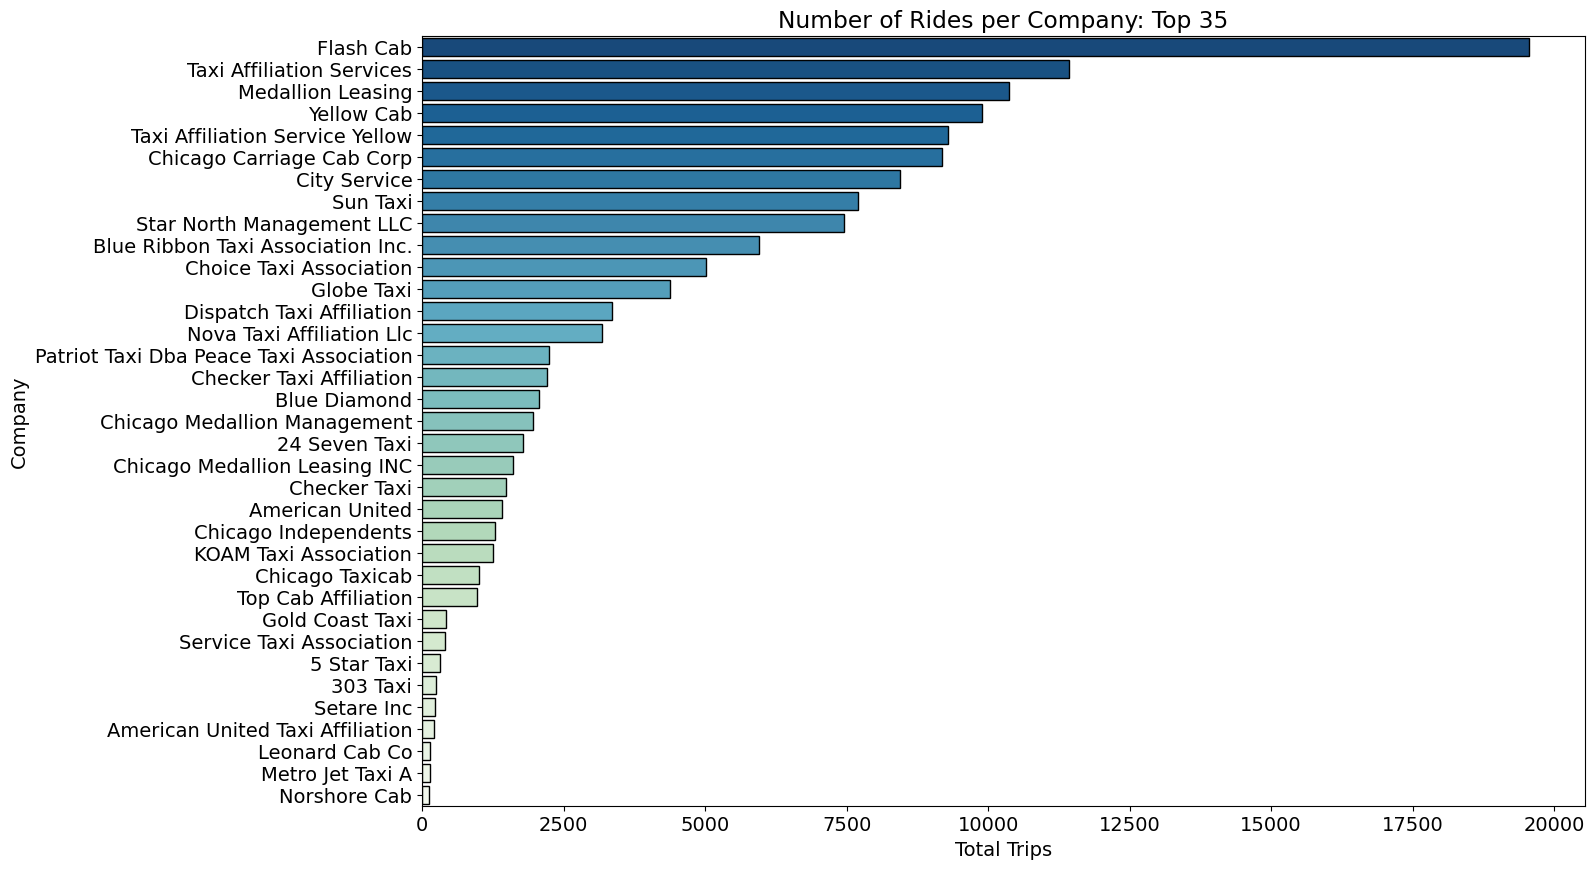

In [134]:
# bar chart showing the number of rides per company for the top 35 active companies
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 14})
sns.barplot(data=company_trips_sorted_df[:35], x='trips_amount', y='company_name', edgecolor='black', palette='GnBu_r')
plt.title('Number of Rides per Company: Top 35')
plt.xlabel('Total Trips')
plt.ylabel('Company')
plt.show()

This next bar chart shows the top 10 neighborhoods by dropoffs.  The two top neighborhood destinations via Taxi in November 2017 were the Loop and River North neighborhoods.  The next closest neighborhood, Streeterville, had a few thousand less dropoffs, with the rest of the pack dropping sharply from there.  I would surmise the top neighborhoods may likely be social hubs that include city centers, event venues, eateries, and other culturally significant establishments.

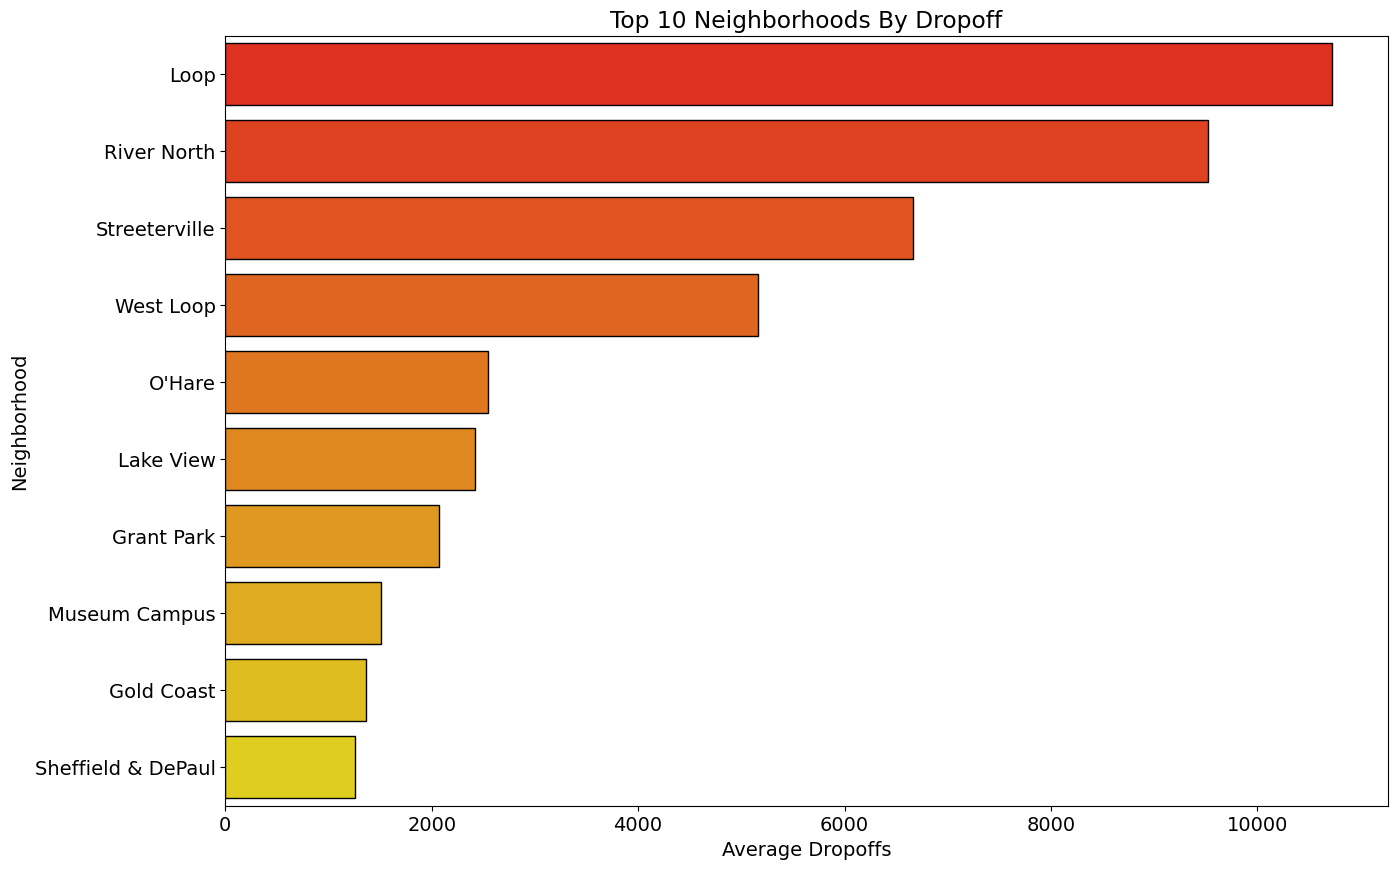

In [135]:
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 14})
sns.barplot(data=top_10_dropoff_hoods[:10], x='average_trips', y='dropoff_location_name', edgecolor='black', palette='autumn')
plt.title('Top 10 Neighborhoods By Dropoff')
plt.xlabel('Average Dropoffs')
plt.ylabel('Neighborhood')
plt.show()

Let's test the hypothesis that the average duration of rides from the Loop neighborhood to O'Hare International Airport changes on rainy Saturdays. For this we will use the airport_weather_df we acquired from the 'project_sql_result_07.csv' obtained from the SQL inquiries, since it's already been parsed into 'Good' and 'Bad' weeather on Saturdays in November 2017.  We will use alpha=0.05, as it is a widely agreed upon critical threshold for statisitcal significance, to determine weather ride times equate.  Our null hypothesis asserts that the ride time is equal, while our alternative hypothesis asserts that ride times are not equal.


## Test Hypothesis:

__H0 = The average ride time from Loop to O'Hare International Airport on rainy Saturdays equals the average ride                     time on non-rainy Saturdays__

__H1 = The average ride time from Loop to O'Hare International Airport on rainy Saturdays does not equal the                             average ride time on non-rainy Saturdays__

In [136]:
# parse dataframe by 'Good' (non-rainy), and 'Bad' (rainy) conditions
rainy = airport_weather_df[(airport_weather_df['weather_conditions'] == 'Bad')]
non_rainy = airport_weather_df[airport_weather_df['weather_conditions'] == 'Good']
# list all ride durations for both conditions
rainy_durations = rainy['duration_seconds'].tolist()
non_rainy_durations = non_rainy['duration_seconds'].tolist()

In [137]:
# Look at the variance in ride duration for both conditions
rainy_durations_var = np.var(rainy)
non_rainy_durations_var = np.var(non_rainy)
rainy_durations_var, non_rainy_durations_var

(duration_seconds    517403.563302
 dtype: float64,
 duration_seconds    575732.93085
 dtype: float64)

In [138]:
alpha = 0.05 # critical statistical significance level

results = st.ttest_ind(rainy_durations, non_rainy_durations, equal_var=False) # test the equality of rides based on rain

print('P-value:', results.pvalue)
# compare the p-value with the significance level
if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We cannot reject the null hypothesis')

P-value: 6.738994326108734e-12
We reject the null hypothesis


## Conclusion:

The findings based on our variances and ttest show that ride times on rainy Saturdays to O'Hare International Airport from the Loop neighborhood are not equal to those on non-rainy Saturdays.  This could be due to increased traffic, increased caution leading to slower driving, or more rides in general overall during "Bad" weather.  Whatever the case, 'Bad' rainy weather tends to increase ride time, which increases revenue for ride-sharing ventures.

Most of these rides were likely from Flash Cab, as we can infer from how many rides they were responsible for in November, as well as the Loop neighborhood being the No. 1 neighborhood for dropoffs in November as well. Thus, I see Flash Cab as Zuber's main competitor in the Chicago ride-sharing space.

With ride-share demand seemingly high in the Loop and River North neighboorhoods, it would be a good place to concentrate first efforts of a ride-sharing platform such as Zuber, especially on rainy days.